# Cost of Wind Energy Review 2022

This example will walk through the process of running the land-based and offshore analyst judement analyses for the 2022 Cost of Wind Energy Review (COWER). This is not the exact workflow because it has been broken down to highlight some of the key features of the WAVES model. Similarly, this will stay up to date with WAVES's dependencies, namely ORBIT, WOMBAT, and FLORIS, so results may change slightly between this *example* relying on the configurations and the reported COE results.

## Imports and Styling

In [1]:
from time import perf_counter
from pathlib import Path

import pandas as pd

from waves import Project
from waves.utilities import load_yaml

# Update core Pandas display settings
pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

## Configuration

First, we need to set the library path, and then we"ll load the configuration file, to show some of the configurations. For a complete guide, please see either the [API documentation](https://nrel.github.io/WAVES/api.html) or the [How to use WAVES guide](https://nrel.github.io/WAVES/getting_started.html#configuring).

In [2]:
library_path = Path("../library/cower_2022/")
config_fixed = load_yaml(library_path / "project/config", "COE_2022_fixed_bottom_base.yaml")
config_floating = load_yaml(library_path / "project/config", "COE_2022_floating_base.yaml")

Now, we"ll create a Project for each of the fixed bottom and floating offshore scenarios.

In [3]:
start = perf_counter()
project_fixed = Project(
    library_path=library_path,  # where to get configurations from
    connect_floris_to_layout=True,  # default; connects FLORIS with layout CSV
    connect_orbit_array_design=True,  # default; adds cable lengths to the layout
    **config_fixed,
)
end = perf_counter()
print(f"Fixed bottom loading time: {(end-start):,.2f} seconds")

start = perf_counter()
project_floating = Project(
    library_path=library_path,  # where to get configurations from
    connect_floris_to_layout=True,  # default; connects FLORIS with layout CSV
    connect_orbit_array_design=True,  # default; adds cable lengths to the layout
    **config_floating,
)
end = perf_counter()
print(f"Floating loading time: {(end-start):,.2f} seconds")

ORBIT library intialized at '/Users/rhammond/GitHub_Public/WAVES/library/cower_2022'


Missing data in columns ['bury_speed']; all values will be calculated.

Fixed bottom loading time: 1.37 seconds
Floating loading time: 1.31 seconds


Missing data in columns ['bury_speed']; all values will be calculated.

Both projects use the same layout, so we"ll plot just the fixed bottom plant, noting that the self-connected line at the "OSS1" indicates the unmodeled interconnection point via a modeled export cable.

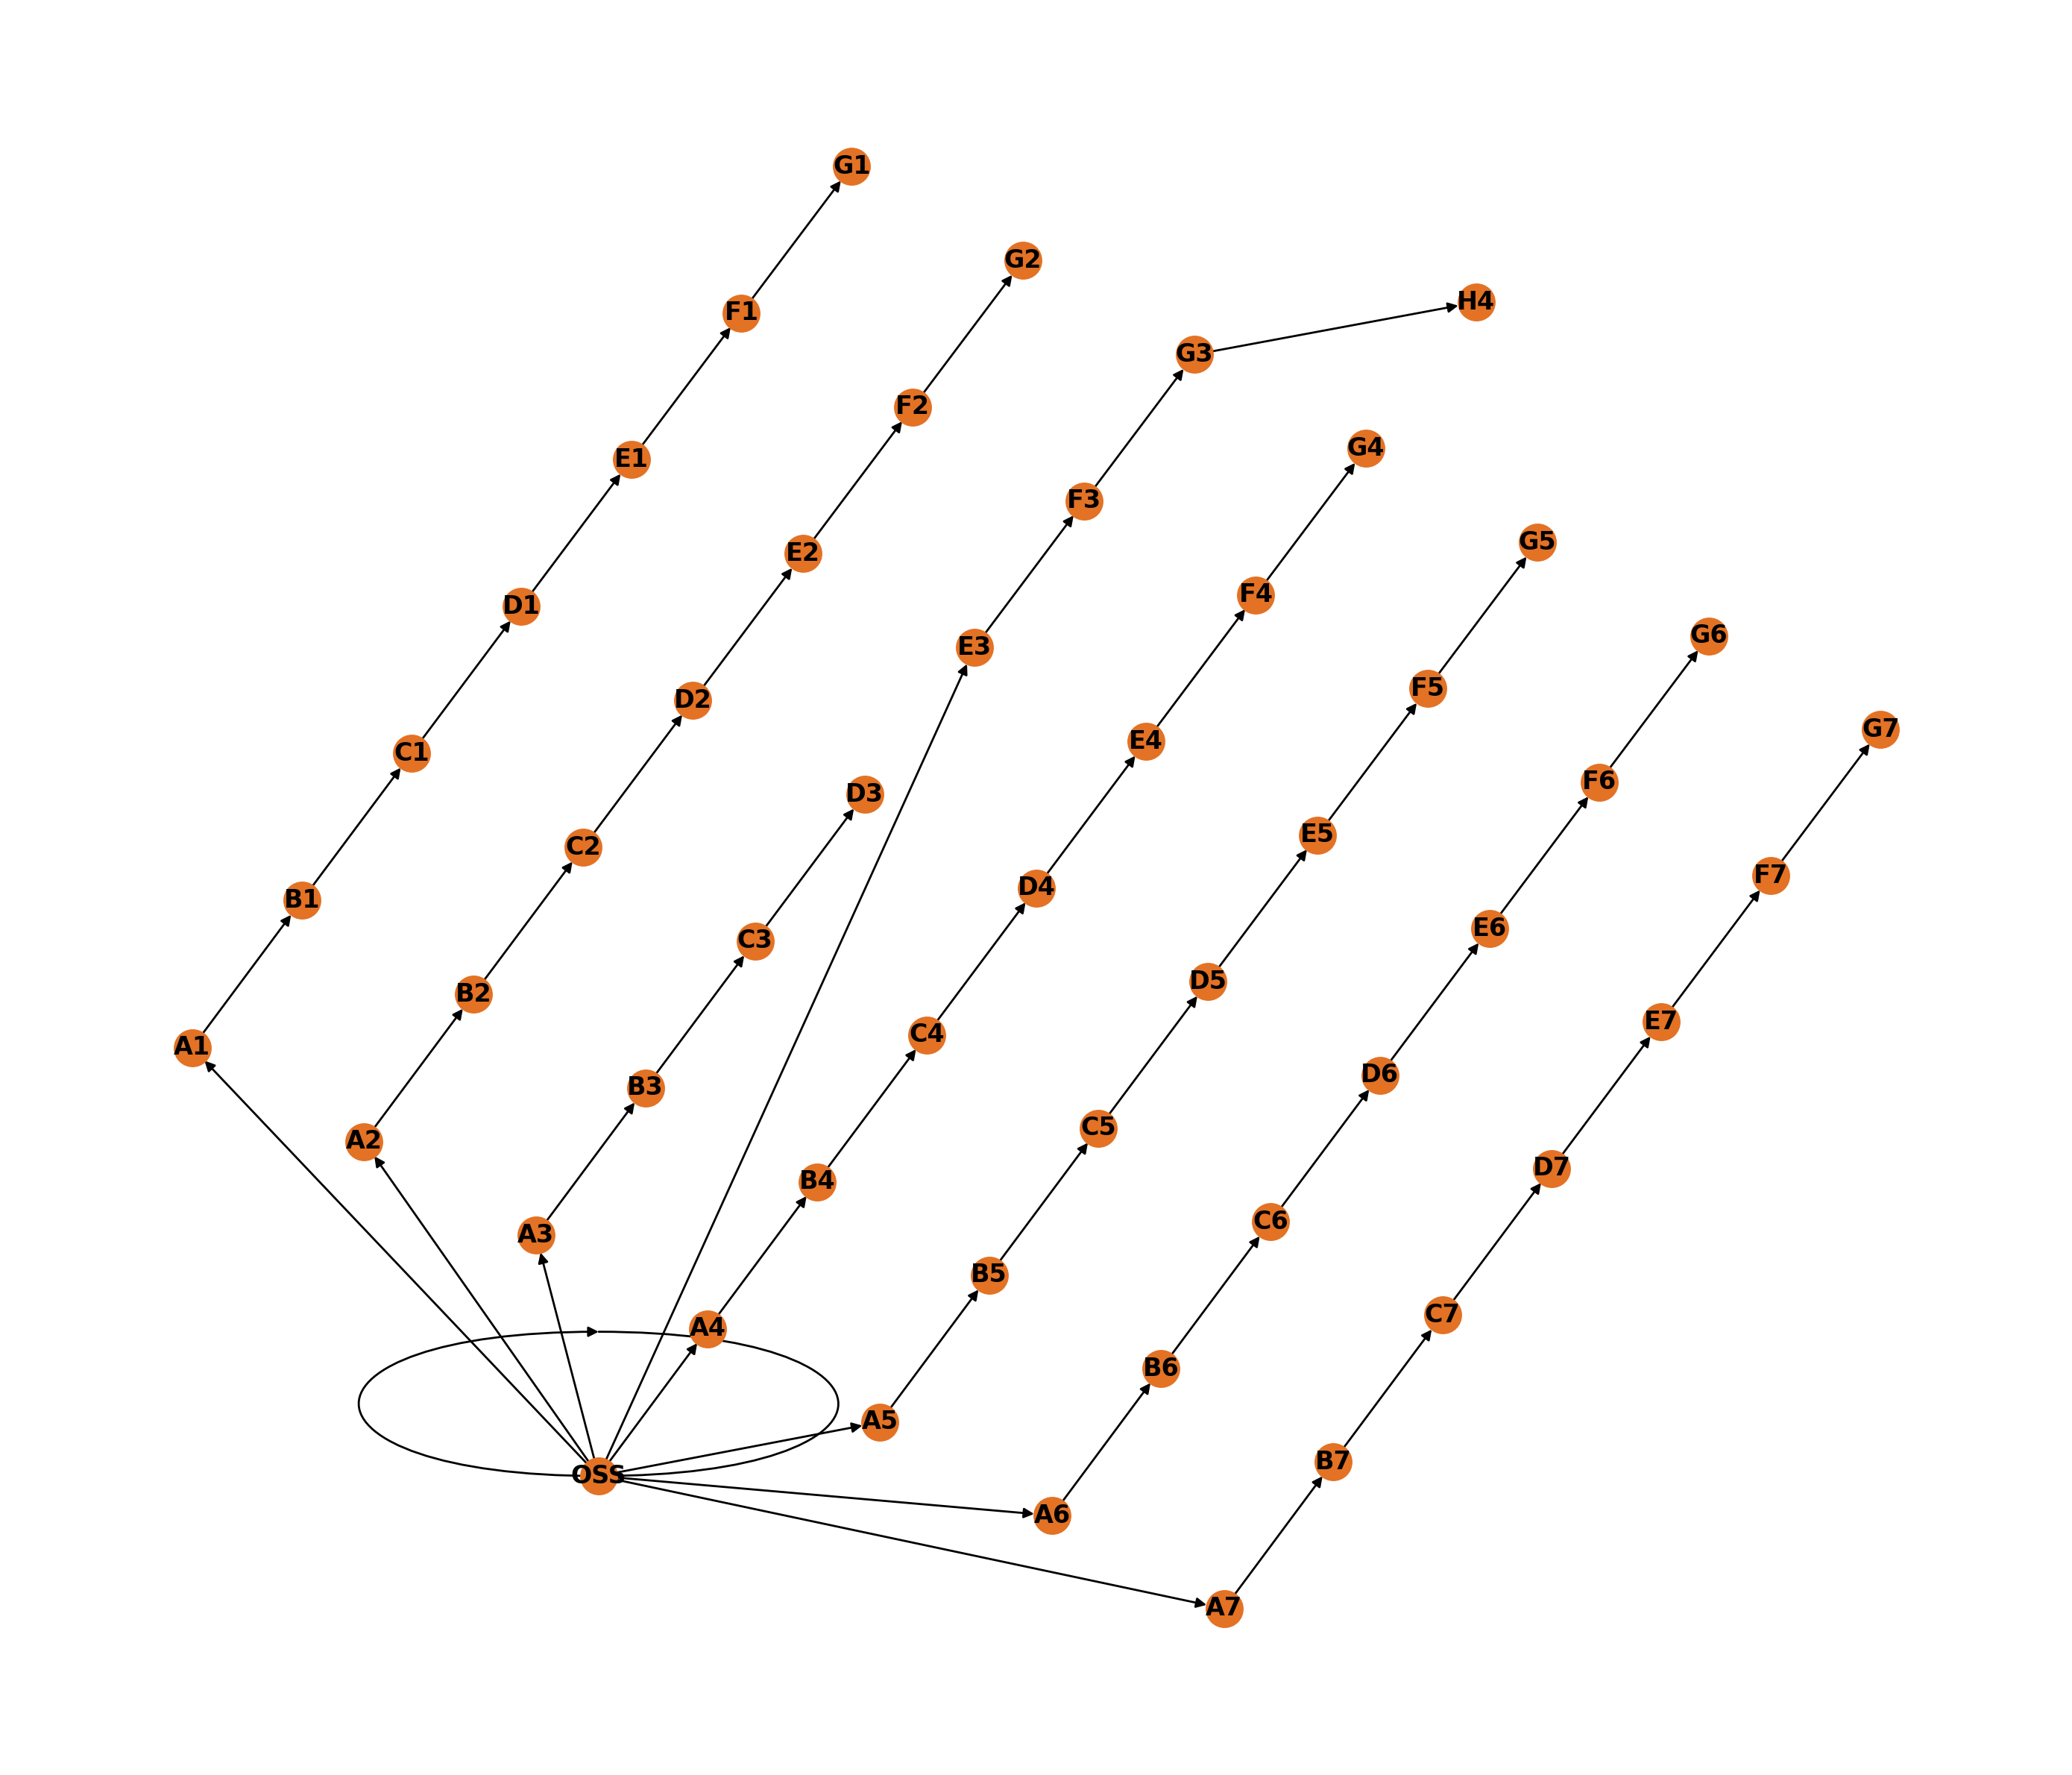

In [4]:
project_fixed.plot_farm()

## Run the Projects

Now we"ll, run all 3 models for both the fixed-bottom and floating offshore wind scenarios. Notice that there are additional parameters to use for running the FLORIS model in WAVES: `"wind_rose"` and `"time_series"`. While time series is more accurate, it can take multiple hours to run for a 20-year, hourly timeseries, and lead to similar results, so we choose the model that can take up to minutes to run, instead.

Additionally, the wind rose can be computed based on the full weather profile, `full_wind_rose=True`, for little added computation since WAVES computes a wind rose for each month of the year, for a more accurate energy output. However, we"re using just the weather profile used in the O&M phase: `full_wind_rose=False`.

In [5]:
start1 = perf_counter()
project_fixed.run(
    which_floris="wind_rose",  # month-based wind rose wake analysis
    full_wind_rose=False,  # use the WOMBAT date range
    floris_reinitialize_kwargs=
        {"cut_in_wind_speed": 3.0, "cut_out_wind_speed": 25.0}  # standard ws range
)
project_fixed.wombat.env.cleanup_log_files()  # Delete logging data from WOMBAT
end1 = perf_counter()
start2 = perf_counter()
project_floating.run(
    which_floris="wind_rose",
    full_wind_rose=False,
    floris_reinitialize_kwargs=dict(cut_in_wind_speed=3.0, cut_out_wind_speed=25.0)
)
project_floating.wombat.env.cleanup_log_files()  # Delete logging data from WOMBAT
end2 = perf_counter()

print(f"Fixed run time: {end1 - start1:,.2f} seconds")
print(f"Floating run time: {end2 - start2:,.2f} seconds")

Missing data in columns ['bury_speed']; all values will be calculated.

Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5


Missing data in columns ['bury_speed']; all values will be calculated.

Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Fixed run time: 61.04 seconds
Floating run time: 65.87 seconds


## Gather the results

Another of the conveniences with using WAVES to run all three models is that some of the core metrics are wrapped in the `Project` API, with the ability to generate a report of a selection of the metrics.

Below, we define the inputs for the report by the following paradigm, where the `"metric"` and `"kwargs"` keys must not be changed to ensure their values are read correctly. See the following setup for details.

```python
configuration_dictionary = {
    "Descriptive Name of Metric": {
        "metric": "metric_method_name",
        "kwargs": {
            "metric_kwarg_1": "kwarg_1_value", ...
        }
    }
}
```

In [6]:
metrics_configuration = {
    "# Turbines": {"metric": "n_turbines", "kwargs": {}},
    "Turbine Rating (MW)": {"metric": "turbine_rating", "kwargs": {}},
    "Project Capacity (MW)": {"metric": "capacity", "kwargs": {"units": "mw"}},
    "# OSS": {"metric": "n_substations", "kwargs": {}},
    "Total Export Cable Length (km)": {"metric": "export_system_total_cable_length", "kwargs": {}},
    "Total Array Cable Length (km)": {"metric": "array_system_total_cable_length", "kwargs": {}},
    "CapEx ($)": {"metric": "capex", "kwargs": {}},
    "CapEx per kW ($/kW)": {"metric": "capex", "kwargs": {"per_capacity": "kw"}},
    "OpEx ($)": {"metric": "opex", "kwargs": {}},
    "OpEx per kW ($/kW)": {"metric": "opex", "kwargs": {"per_capacity": "kw"}},
    "AEP (MWh)": {
        "metric": "energy_production",
        "kwargs": {"units": "mw", "aep": True, "with_losses": True}
    },
    "AEP per kW (MWh/kW)": {
        "metric": "energy_production",
        "kwargs": {"units": "mw", "per_capacity": "kw", "aep": True, "with_losses": True}
    },
    "Net Capacity Factor With Wake Losses (%)": {
        "metric": "capacity_factor",
        "kwargs": {"which": "net"}
    },
    "Net Capacity Factor With All Losses (%)": {
        "metric": "capacity_factor",
        "kwargs": {"which": "net", "with_losses": True}
    },
    "Gross Capacity Factor (%)": {"metric": "capacity_factor", "kwargs": {"which": "gross"}},
    "Energy Availability (%)": {"metric": "availability", "kwargs": {"which": "energy"}},
    "LCOE ($/MWh)": {"metric": "lcoe", "kwargs": {}},
}


# Define the final order of the metrics in the resulting dataframe
metrics_order = [
    "# Turbines",
    "Turbine Rating (MW)",
    "Project Capacity (MW)",
    "# OSS",
    "Total Export Cable Length (km)",
    "Total Array Cable Length (km)",
    "FCR (%)",
    "Offtake Price ($/MWh)",
    "CapEx ($)",
    "CapEx per kW ($/kW)",
    "OpEx ($)",
    "OpEx per kW ($/kW)",
    "Annual OpEx per kW ($/kW)",
    "Energy Availability (%)",
    "Gross Capacity Factor (%)",
    "Net Capacity Factor With Wake Losses (%)",
    "Net Capacity Factor With All Losses (%)",
    "AEP (MWh)",
    "AEP per kW (MWh/kW)",
    "LCOE ($/MWh)",
]
final_cols = ["CapEx ($)", "OpEx ($)", "Energy Production (GWh)", "Revenue ($)", "Cash Flow ($)"]

capex_order = [
    "Array System",
    "Export System",
    "Offshore Substation",
    "Substructure",
    "Scour Protection",
    "Mooring System",
    "Turbine",
    "Array System Installation",
    "Export System Installation",
    "Offshore Substation Installation",
    "Substructure Installation",
    "Scour Protection Installation",
    "Mooring System Installation",
    "Turbine Installation",
    "Soft",
    "Project",
]

Before we generate the report, let"s see a CapEx breakdown of each scenario.

In [7]:
df_capex_fixed = pd.DataFrame(
    project_fixed.orbit.capex_breakdown.items(),
    columns=["Component", "CapEx ($) - Fixed"]
)
df_capex_fixed["CapEx ($/kW) - Fixed"] = df_capex_fixed["CapEx ($) - Fixed"] / project_fixed.capacity("kw")

df_capex_floating = pd.DataFrame(
    project_floating.orbit.capex_breakdown.items(),
    columns=["Component", "CapEx ($) - Floating"]
)
df_capex_floating["CapEx ($/kW) - Floating"] = df_capex_floating["CapEx ($) - Floating"] / project_floating.capacity("kw")

df_capex = df_capex_fixed.merge(
    df_capex_floating,
    on="Component",
    how="outer",
).fillna(0.0).set_index("Component")
df_capex = df_capex.iloc[pd.Categorical(df_capex.index, capex_order).argsort()]
df_capex

,CapEx ($) - Fixed,CapEx ($/kW) - Fixed,CapEx ($) - Floating,CapEx ($/kW) - Floating
Component,,,,
Array System,"111,193,235.71",185.32,"133,234,144.17",222.06
Export System,"100,357,800.00",167.26,"75,794,538.61",126.32
Offshore Substation,"99,479,100.00",165.80,"99,479,100.00",165.80
Substructure,"307,153,308.59",511.92,"630,709,636.60","1,051.18"
Scour Protection,"10,242,000.00",17.07,0.00,0.00
Mooring System,0.00,0.00,"275,612,740.33",459.35
Turbine,"900,000,000.00","1,500.00","900,000,000.00","1,500.00"
Array System Installation,"47,558,925.93",79.26,"73,064,693.30",121.77
Export System Installation,"121,367,306.76",202.28,"124,828,794.96",208.05


No, let's generate the report, and then add in some additional reporting variables.

In [8]:
project_name_fixed = "COE 2022 - Fixed"
report_df_fixed = project_fixed.generate_report(metrics_configuration, project_name_fixed).T
additional_reporting_fixed = pd.DataFrame(
    [
        ["FCR (%)", project_fixed.fixed_charge_rate],
        ["Offtake Price ($/MWh)", project_fixed.offtake_price],
        ["Annual OpEx per kW ($/kW)", report_df_fixed.loc["OpEx per kW ($/kW)", project_name_fixed] / project_fixed.operations_years],
    ],
    columns=["Project"] + report_df_fixed.columns.tolist(),
).set_index("Project")
report_df_fixed = pd.concat((report_df_fixed, additional_reporting_fixed), axis=0).loc[metrics_order]

project_name_floating = "COE 2022 - Floating"
report_df_floating = project_floating.generate_report(metrics_configuration, project_name_floating).T
additional_reporting_floating = pd.DataFrame(
    [
        ["FCR (%)", project_floating.fixed_charge_rate],
        ["Offtake Price ($/MWh)", project_floating.offtake_price],
        ["Annual OpEx per kW ($/kW)", report_df_floating.loc["OpEx per kW ($/kW)", project_name_floating] / project_floating.operations_years],
    ],
    columns=["Project"] + report_df_floating.columns.tolist(),
).set_index("Project")
report_df_floating = pd.concat((report_df_floating, additional_reporting_floating), axis=0).loc[metrics_order]

report_df = report_df_fixed.join(
    report_df_floating,
    how="outer",
).fillna(0.0)
report_df.index.name = "Metrics"
report_df

,COE 2022 - Fixed,COE 2022 - Floating
Metrics,,
# Turbines,50.00,50.00
Turbine Rating (MW),12.00,12.00
Project Capacity (MW),600.00,600.00
# OSS,1.00,1.00
Total Export Cable Length (km),118.07,89.17
Total Array Cable Length (km),277.98,333.09
FCR (%),0.06,0.06
Offtake Price ($/MWh),83.30,83.30
CapEx ($),"2,287,510,098.20","2,915,072,953.79"
